# June 30th, 2021

**Motivation**: Hierarchical results much better, now making reasonable reproducibility figures <br>


In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, 'Ca-fMRI'))
from register.atlas import load_allen, load_bg_atlas
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.helper import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def hierarchical_compare(
        hierarchical: dict,
        n_clusters: Union[range, list],
        key_fx: str = 'sub-SLC',
        keys_mv: List[str] = None,
        dist_measure: str = 'dice',
        cmap='RdYlBu_r',
        figsize=None, ):
    
    allen = hierarchical[key_fx].mice.allen
    contour = hierarchical[key_fx].mice.parcel.results2d['contour']
    
    keys_mv = keys_mv if keys_mv else ['ses-1', 'ses-2', 'ses-3']
    nrows, ncols = len(keys_mv) + 1, len(n_clusters)
    figsize = figsize if figsize else (13.5, 1.75 * nrows)
    fig, axes = create_figure(nrows, ncols, figsize=figsize)

    match_results = {}
    for j, n in tqdm(enumerate(n_clusters), total=len(n_clusters), leave=False):
        fx_cluster = hierarchical[key_fx].clusters[n]
        fx_masks = {i: fx_cluster.x == i for i in fx_cluster.idxs}
        _, x2d = masks2cluster(fx_masks, allen)
        
        cond = np.logical_or(contour, x2d == 0)
        _cond, _x = filter_boundaries([cond, x2d], mask=x2d.astype(bool))
        data2plt = np.ma.masked_where(_cond, _x)
        axes[0, j].imshow(data2plt, cmap=cmap)
        axes[0, j].set_title(f"n = {n}", fontsize=17, y=1.06)
        if j == 0:
            axes[0, j].set_ylabel(f"{key_fx}\n", fontsize=13)

        for i, key in enumerate(keys_mv):
            mv_cluster = hierarchical[key].clusters[n]
            mv_masks = {ii: mv_cluster.x == ii for ii in mv_cluster.idxs}
            scores, mappings = clusters_sim_scores(fx_masks, mv_masks)
            match_results['_vs_'.join([key_fx, key])] = (scores, mappings)

            mv_algn = {
                list(fx_masks)[mappings[dist_measure][ii]]: m
                for ii, m in enumerate(mv_masks.values())
            }
            _, x2d_algn = masks2cluster(mv_algn, allen)

            cond = np.logical_or(contour, x2d_algn == 0)
            _cond, _x = filter_boundaries([cond, x2d_algn], mask=x2d_algn.astype(bool))
            data2plt = np.ma.masked_where(_cond, _x)
            axes[i + 1, j].imshow(data2plt, cmap=cmap)
            if j == 0:
                axes[i + 1, j].set_ylabel(f"{key}\n", fontsize=12)
    remove_ticks(axes)
    return match_results

## Load & prepare

### Mice

In [6]:
start = time()
mice = Mice(Config(100))
end = time()

_ = convert_time(end - start)

00 - 00:00:03  (dd - hh:mm:ss)

In [7]:
len(mice.bold_df_piv)

204

In [8]:
mice.combine_dfs('rest')
len(mice.bold_combined)

44

### parcellation

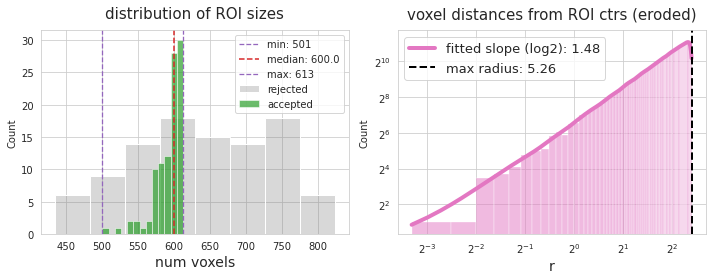

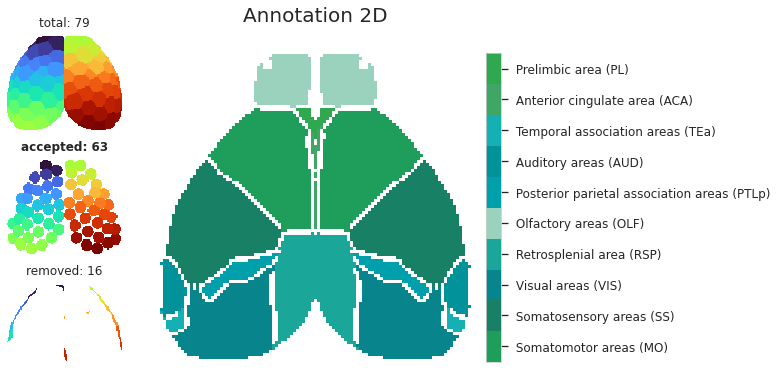

In [9]:
_ = mice.parcel.show()
_ = mice.parcel.show_2d()

## Dice

### Load Hier

In [10]:
mice = Mice(Config(100))
mice.combine_dfs('rest')

In [11]:
metric = 'correlation'
load_dir = pjoin(mice.cfg.results_dir, f"hierarchical")
load_dir = pjoin(load_dir, sorted([x for x in os.listdir(load_dir) if metric in x])[-1])

hex2key = np.load(pjoin(load_dir, 'hex2key.npy'), allow_pickle=True).item()
key2hex = {k: h for h, k in hex2key.items()}

load_dir

'/home/hadi/Documents/Ca-fMRI/processed/kmeans-100/results/hierarchical/correlation-(2021_06_30)'

In [12]:
len(os.listdir(pjoin(load_dir, 'fits')))

81

In [13]:
os.listdir(pjoin(load_dir, 'fits'))[0]

'bdd640fb.npy'

In [15]:
list(hex2key)[0]

'bdd640fb'

In [16]:
def load_timing(file_name):
    return Hierarchical(mice, metric=metric).load(file_name, load_dir)

def load_timing2(file_name):
    return Hierarchical(mice, metric=metric).load(file_name, load_dir).make_cluster_masks()

def load_timing3(file_name):
    return Hierarchical(mice, metric=metric).load(file_name, load_dir).make_clusters()

In [11]:
%timeit load_timing('bdd640fb')

69 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit load_timing2('bdd640fb')

4.48 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit load_timing3('bdd640fb')

1min 28s ± 882 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
f = 'bdd640fb'
hier = Hierarchical(mice, metric=metric).load(f)
list(hier.results[5])

[
    'cluster_classes',
    'cluster_assigns',
    'cluster_colors',
    'dendogram',
    'fig',
    'ax'
]

In [16]:
f = 'bdd640fb'
hier = Hierarchical(mice, metric=metric).load(f).make_cluster_masks()
list(hier.results[5])

[
    'cluster_masks',
    'cluster_classes',
    'cluster_assigns',
    'cluster_colors',
    'dendogram',
    'fig',
    'ax'
]

In [17]:
f = 'bdd640fb'
hier = Hierarchical(mice, metric=metric).load(f, make=True)
list(hier.results[5])

[
    'cluster_masks',
    'cluster_classes',
    'cluster_assigns',
    'cluster_colors',
    'dendogram',
    'fig',
    'ax'
]

In [18]:
len(hier.results), len(hier.clusters)

(18, 18)

In [20]:
hier.clusters[5]

STR C_3 100% PAL C_3 100% OLF C_3 100% CTXsp C_2 50% C_3 50% HPF C_2 50% C_3 50% VIS C_1 52% C_2 48% TEa C_2 56% C_3 25% C_5 11% C_1 8% PERI C_2 57% C_3 43% ECT C_2 58% C_3 42% RSP C_1 85% C_2 15% AUD C_5 68% C_2 24% C_1 7% C_3 1% PTLp C_1 84% C_2 16% VISC C_5 46% C_2 40% C_3 13% C_4 2% SS C_5 81% C_1 16% C_2 2% SSp C_5 76% C_1 22% C_2 2% SSp-bfd C_5 76% C_1 15% C_2 9% SSp-ll C_1 80% C_5 20% SSp-m C_5 100% SSp-n C_5 100% SSp-tr C_1 92% C_5 8% SSp-ul C_5 75% C_1 25% SSp-un C_5 79% C_1 21% SSs C_5 96% C_1 2% C_2 2% C_4 1% GU C_4 49% C_5 45% C_2 5% ACA C_1 100% AI C_4 71% C_5 17% C_2 12% C_3 1% MO C_5 53% C_1 34% C_4 13% MOp C_5 74% C_1 23% C_4 3% MOs C_1 43% C_5 36% C_4 21% ILA C_1 100% PL C_1 98% C_5 2% ORB C_1 52% C_4 47% C_5 1% FRP C_4 58% C_1 39% C_5 3%

In [21]:
_ = cluster2html(
    cluster=hier.clusters[5],
    save_name='CORR-REST',
    n_cortex_regions=hier.mice.parcel.results['n_cortical_regions'],
    save_dir=extras_dir,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/CORR-REST_render-100_n-5.html

In [ ]:
fits = ['8bea75c1', 'bdd640fb', '6db99102', '1777e8cb']

hierarchical = {}
for f in tqdm(fits):
    hierarchical[hex2key[f]] = Hierarchical(
        mice=mice,
        metric=metric,
    ).load(f, load_dir, make=True)
list(hierarchical)

  0%|          | 0/8 [00:00<?, ?it/s]

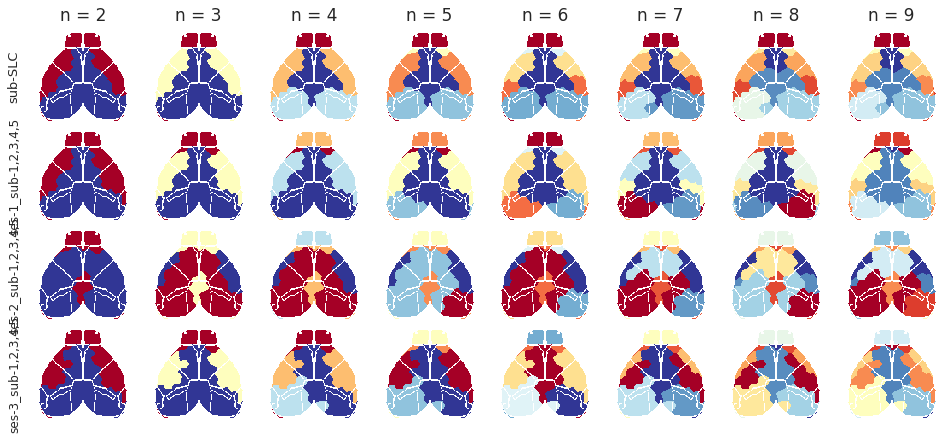

In [23]:
match_results = hierarchical_compare(
    hierarchical=hierarchical,
    n_clusters=range(2, 10),
    key_fx=list(hierarchical)[0],
    keys_mv=list(hierarchical)[1:],
    figsize=(13.5, 6),
)

In [62]:
s = '+'.join(list(hierarchical.keys())[:5])
s

'sub-SLC01_ses-1+sub-SLC01_ses-2+sub-SLC01_ses-3+sub-SLC02_ses-1+sub-SLC02_ses-2'

In [63]:
s.encode()

b'sub-SLC01_ses-1+sub-SLC01_ses-2+sub-SLC01_ses-3+sub-SLC02_ses-1+sub-SLC02_ses-2'

In [64]:
s_hex = s.encode().hex()
s_hex

'7375622d534c4330315f7365732d312b7375622d534c4330315f7365732d322b7375622d534c4330315f7365732d332b7375622d534c4330325f7365732d312b7375622d534c4330325f7365732d32'

In [65]:
s_int = int(s_hex, 16)
s_int

8037913265811786904448598936035276419589592526616155294808568635300286085246012416705591517440691562715085550654213140059736585601562603880497138765744429477641200319650797750956610085399858

In [66]:
bytes.fromhex(s_hex).decode('utf-8')

'sub-SLC01_ses-1+sub-SLC01_ses-2+sub-SLC01_ses-3+sub-SLC02_ses-1+sub-SLC02_ses-2'

In [27]:
combos = []
for a in itertools.combinations(mice.cfg.sub_ids, mice.cfg.num_subjects // 2):
    combos.append(list(a))
pairs = [(combos[i], combos[-i-1]) for i in range(len(combos)//2)]
assert all(set(x[0] + x[1]) == set(mice.cfg.sub_ids) for x in pairs)

len(combos), len(pairs)

(252, 126)

In [28]:
pairs[54]

([1, 2, 7, 9, 10], [3, 4, 5, 6, 8])

In [48]:
key2hex = {}
for s in [[1], [2], [3], [1, 2, 3]]:
    for a in combos:
        key_ses = ','.join([str(x) for x in s])
        key_sub = ','.join([str(x) for x in a])
        key = f"ses-{key_ses}_sub-{key_sub}"
        key2hex[key] = get_hex_string()
hex2key = {h: k for k, h in key2hex.items()}

In [49]:
key2hex

{
    'ses-1_sub-1,2,3,4,5': '0ec0713d',
    'ses-1_sub-1,2,3,4,6': '6aa0426d',
    'ses-1_sub-1,2,3,4,7': '636f6e5c',
    'ses-1_sub-1,2,3,4,8': '548c1d84',
    'ses-1_sub-1,2,3,4,9': '73253aa3',
    'ses-1_sub-1,2,3,4,10': '891f6912',
    'ses-1_sub-1,2,3,5,6': '0d31812e',
    'ses-1_sub-1,2,3,5,7': '9adf4709',
    'ses-1_sub-1,2,3,5,8': '12a1fe7d',
    'ses-1_sub-1,2,3,5,9': '966be275',
    'ses-1_sub-1,2,3,5,10': '378e6510',
    'ses-1_sub-1,2,3,6,7': 'e8334da5',
    'ses-1_sub-1,2,3,6,8': 'e8b3d763',
    'ses-1_sub-1,2,3,6,9': '30a5648e',
    'ses-1_sub-1,2,3,6,10': 'bf337a15',
    'ses-1_sub-1,2,3,7,8': 'ea18d32c',
    'ses-1_sub-1,2,3,7,9': 'b42a2d93',
    'ses-1_sub-1,2,3,7,10': '3d44cb2c',
    'ses-1_sub-1,2,3,8,9': '48769153',
    'ses-1_sub-1,2,3,8,10': 'a6129a1c',
    'ses-1_sub-1,2,3,9,10': '5c11ab6d',
    'ses-1_sub-1,2,4,5,6': '774c0afa',
    'ses-1_sub-1,2,4,5,7': 'b8f0188e',
    'ses-1_sub-1,2,4,5,8': '51facefa',
    'ses-1_sub-1,2,4,5,9': '501ba851',
    'ses-1_sub-1,2,4,5,10': 'dd34aa18',
    'ses-1_sub-1,2,4,6,7': '0426fcc9',
    'ses-1_sub-1,2,4,6,8': '95831d58',
    'ses-1_sub-1,2,4,6,9': '4b91b8cb',
    'ses-1_sub-1,2,4,6,10': '3ae28023',
    'ses-1_sub-1,2,4,7,8': '3ee82983',
    'ses-1_sub-1,2,4,7,9': 'f186e47a',
    'ses-1_sub-1,2,4,7,10': 'c36b9a0a',
    'ses-1_sub-1,2,4,8,9': 'b93b17fb',
    'ses-1_sub-1,2,4,8,10': '75f8e3a8',
    'ses-1_sub-1,2,4,9,10': '5a2837b2',
    'ses-1_sub-1,2,5,6,7': '8bea75c1',
    'ses-1_sub-1,2,5,6,8': 'e3ad64d4',
    'ses-1_sub-1,2,5,6,9': 'f50d7a37',
    'ses-1_sub-1,2,5,6,10': 'd6cd3155',
    'ses-1_sub-1,2,5,7,8': 'd1682e09',
    'ses-1_sub-1,2,5,7,9': '01a25ed1',
    'ses-1_sub-1,2,5,7,10': 'a175a9c3',
    'ses-1_sub-1,2,5,8,9': '26a9e100',
    'ses-1_sub-1,2,5,8,10': '74bd0c93',
    'ses-1_sub-1,2,5,9,10': 'a3422e50',
    'ses-1_sub-1,2,6,7,8': 'e9aa144b',
    'ses-1_sub-1,2,6,7,9': '0406ff44',
    'ses-1_sub-1,2,6,7,10': '694d7b00',
    'ses-1_sub-1,2,6,8,9': 'b8e19f56',
    'ses-1_sub-1,2,6,8,10': '49646b96',
    'ses-1_sub-1,2,6,9,10': 'b2a6e468',
    'ses-1_sub-1,2,7,8,9': 'f090f5a0',
    'ses-1_sub-1,2,7,8,10': 'eb053fc4',
    'ses-1_sub-1,2,7,9,10': '3db02235',
    'ses-1_sub-1,2,8,9,10': '409e7a80',
    'ses-1_sub-1,3,4,5,6': 'cb80f288',
    'ses-1_sub-1,3,4,5,7': 'f5948a54',
    'ses-1_sub-1,3,4,5,8': '3e42df5b',
    'ses-1_sub-1,3,4,5,9': '4ccb2355',
    'ses-1_sub-1,3,4,5,10': '14a34f7f',
    'ses-1_sub-1,3,4,6,7': 'a65f7b8a',
    'ses-1_sub-1,3,4,6,8': '67c0518b',
    'ses-1_sub-1,3,4,6,9': '79db7862',
    'ses-1_sub-1,3,4,6,10': 'b3eda8f1',
    'ses-1_sub-1,3,4,7,8': 'd867888b',
    'ses-1_sub-1,3,4,7,9': '54ce26be',
    'ses-1_sub-1,3,4,7,10': 'f94d8fcb',
    'ses-1_sub-1,3,4,8,9': 'eb4d8f42',
    'ses-1_sub-1,3,4,8,10': 'e6b9d31a',
    'ses-1_sub-1,3,4,9,10': '9118c400',
    'ses-1_sub-1,3,5,6,7': 'ec95b3ac',
    'ses-1_sub-1,3,5,6,8': '47c68688',
    'ses-1_sub-1,3,5,6,9': 'a879d8f8',
    'ses-1_sub-1,3,5,6,10': 'd9b59f84',
    'ses-1_sub-1,3,5,7,8': '3508507a',
    'ses-1_sub-1,3,5,7,9': 'd218c9d6',
    'ses-1_sub-1,3,5,7,10': 'edcabf94',
    'ses-1_sub-1,3,5,8,9': '905f9096',
    'ses-1_sub-1,3,5,8,10': 'd9750f00',
    'ses-1_sub-1,3,5,9,10': '8a624cbd',
    'ses-1_sub-1,3,6,7,8': 'bd5ff093',
    'ses-1_sub-1,3,6,7,9': 'b076a7dc',
    'ses-1_sub-1,3,6,7,10': 'bed63da0',
    'ses-1_sub-1,3,6,8,9': '1901ef87',
    'ses-1_sub-1,3,6,8,10': '1375ee90',
    'ses-1_sub-1,3,6,9,10': '9d264599',
    'ses-1_sub-1,3,7,8,9': 'f80b2cea',
    'ses-1_sub-1,3,7,8,10': 'a255e1bb',
    'ses-1_sub-1,3,7,9,10': '735741e5',
    'ses-1_sub-1,3,8,9,10': '8d93e14a',
    'ses-1_sub-1,4,5,6,7': '2f8c83e5',
    'ses-1_sub-1,4,5,6,8': '614c721d',
    'ses-1_sub-1,4,5,6,9': '4b9dfd58',
    'ses-1_sub-1,4,5,6,10': '12d15585',
    'ses-1_sub-1,4,5,7,8': '6147adeb',
    'ses-1_sub-1,4,5,7,9': '277eb0aa',
    'ses-1_sub-1,4,5,7,10': '5c56d9bc',
    'ses-1_sub-1,4,5,8,9': 'f165d779',
    'ses-1_sub-1,4,5,8,10': 'c2e79a98',
    'ses-1_sub-1,4,5,9,10': '16591c89',
    'ses-1_sub-1,4,

In [45]:
hex2key[f]

'ses-1_sub-1,2,3,4,5'

In [22]:
hier = Hierarchical(
    mice=mice,
    metric=metric,
).load(f).make_cluster_masks()

In [42]:
masks = hier.results[10]['cluster_masks']

In [43]:
x3d, x2d = masks2cluster(masks, mice.allen)

<matplotlib.image.AxesImage object at 0x7fa2487571c0>

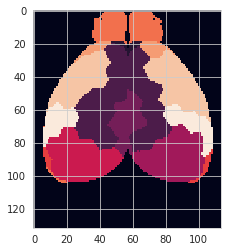

In [44]:
plt.imshow(x2d)

## Finish

In [14]:
n_rois = 128
mice = Mice(Config(n_rois))
mice.combine_dfs('rest')

In [15]:
metric = 'correlation'
load_dir = pjoin(mice.cfg.results_dir, f"hierarchical")
load_dir = pjoin(load_dir, sorted([x for x in os.listdir(load_dir) if metric in x])[-1])
c_masks_dir = pjoin(load_dir, 'cluster_masks')

hex2key = np.load(pjoin(load_dir, 'hex2key.npy'), allow_pickle=True).item()
key2hex = {k: h for h, k in hex2key.items()}

load_dir

'/home/hadi/Documents/Ca-fMRI/processed/kmeans-128/results/hierarchical/correlation-(2021_06_30)'

In [16]:
len(os.listdir(pjoin(load_dir, 'fits'))), len(os.listdir(c_masks_dir))

(1052, 1052)

In [17]:
combos = []
for a in itertools.combinations(mice.cfg.sub_ids, mice.cfg.num_subjects // 2):
    combos.append(list(a))
pairs = [(combos[i], combos[-i - 1]) for i in range(len(combos) // 2)]
assert all(set(x[0] + x[1]) == set(mice.cfg.sub_ids) for x in pairs)

len(combos), len(pairs)

(252, 126)

### Make repro figs

In [18]:
dict_list = []
n_clusters = range(2, 10)

#### Condition 1: between sessions

In [19]:
condition = 'between-ses'

pbar = tqdm(combos)
for a in pbar:
    key_sub = f"sub-{','.join([str(x) for x in a])}"
    selected = {}
    for s in [[1], [2], [3]]:
        key_ses = f"ses-{','.join([str(x) for x in s])}"
        key = '_'.join([key_ses, key_sub])
        hex_f = key2hex[key]
        pbar.set_description(f"{key},\tfile name: {hex_f}")
        
        selected[key_ses] = np.load(
            pjoin(c_masks_dir, f"{hex_f}.npy"),
            allow_pickle=True,
        ).item()

    for k1, k2 in tqdm(itertools.combinations(selected, 2), leave=False):
        for n in n_clusters:
            m1 = selected[k1][n]
            m2 = selected[k2][n]
            scores, mappings = clusters_sim_scores(m1, m2)
            for k, v in scores.items():
                data_dict = {
                    'condition': [condition],
                    'n_rois': [mice.parcel.results['n_cortical_regions']],
                    'n_clusters': [n],
                    'metric': [metric],
                    'dist_measure': [k],
                    'val_mean': [np.mean(np.diag(v))],
                    'val_median': [np.median(np.diag(v))],
                }
                dict_list.append(data_dict)

  0%|          | 0/252 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

#### Condition 2: between subjects (same session)

In [20]:
condition = 'between-sub'

pbar = tqdm(pairs)
for a, b in pbar:
    _key_a = f"sub-{','.join([str(x) for x in a])}"
    _key_b = f"sub-{','.join([str(x) for x in b])}"

    for s in [[1], [2], [3]]:
        key_ses = f"ses-{','.join([str(x) for x in s])}"
        key_a = '_'.join([key_ses, _key_a])
        key_b = '_'.join([key_ses, _key_b])
        hex_f_a = key2hex[key_a]
        hex_f_b = key2hex[key_b]
        pbar.set_description(f"{key_ses}  (a: {hex_f_a}, b: {hex_f_b})")
        
        m_a = np.load(
            pjoin(c_masks_dir, f"{hex_f_a}.npy"),
            allow_pickle=True,
        ).item()
        m_b = np.load(
            pjoin(c_masks_dir, f"{hex_f_b}.npy"),
            allow_pickle=True,
        ).item()
        
        for n in n_clusters:
            scores, mappings = clusters_sim_scores(m_a[n], m_b[n])
            for k, v in scores.items():
                data_dict = {
                    'condition': [condition],
                    'n_rois': [mice.parcel.results['n_cortical_regions']],
                    'n_clusters': [n],
                    'metric': [metric],
                    'dist_measure': [k],
                    'val_mean': [np.mean(np.diag(v))],
                    'val_median': [np.median(np.diag(v))],
                }
                dict_list.append(data_dict)

  0%|          | 0/126 [00:00<?, ?it/s]

#### Get results df

In [21]:
results_df = pd.DataFrame(merge_dicts(dict_list))
results_df.to_pickle(pjoin(tmp_dir, f"results_n{n_rois}.df"))
results_df.shape

...merging dicts: 0it [00:00, ?it/s]

(27216, 7)

#### Save fig

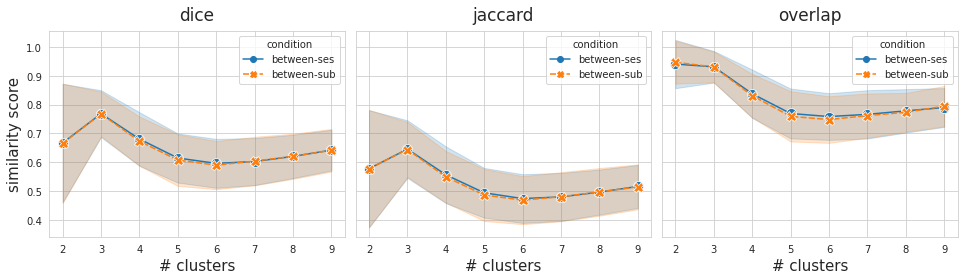

In [22]:
fig, axes = create_figure(1, 3, (13.5, 4), True, 'whitegrid', 'all', 'all')

for ax, dist_measure in zip(axes, ['dice', 'jaccard', 'overlap']):
    selected_df = results_df.loc[
        (results_df.dist_measure == dist_measure) &
        (results_df.n_rois == n_rois)
    ]
    sns.lineplot(
        data=selected_df,
        x='n_clusters',
        y='val_mean',
        hue='condition',
        style='condition',
        markers=True,
        markersize=10,
        estimator=np.mean,
        ci='sd',
        legend=True,
        ax=ax,
    )
    ax.set_title(dist_measure, fontsize=17, y=1.02)
    ax.set_ylabel('similarity score', fontsize=15)
    ax.set_xlabel('# clusters', fontsize=15)
    ax.set_xticks(results_df.n_clusters.unique())

fig.savefig(pjoin(tmp_dir, f"reproducibility_n{n_rois}.pdf"), bbox_inches='tight')
plt.show()

In [24]:
results_df.shape

(27216, 7)

In [25]:
condition = 'between-ses'

pbar = tqdm(combos)
for a in pbar:
    key_sub = f"sub-{','.join([str(x) for x in a])}"
    selected = {}
    for s in [[1], [2], [3]]:
        key_ses = f"ses-{','.join([str(x) for x in s])}"
        key = '_'.join([key_ses, key_sub])
        hex_f = key2hex[key]
        selected[key_ses] = 0
    for k1, k2 in tqdm(itertools.combinations(selected, 2), leave=False):
        print(key_sub, k1, k2)

  0%|          | 0/252 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sub-1,2,3,4,5 ses-1 ses-2

sub-1,2,3,4,5 ses-1 ses-3

sub-1,2,3,4,5 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,4,6 ses-1 ses-2

sub-1,2,3,4,6 ses-1 ses-3

sub-1,2,3,4,6 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,4,7 ses-1 ses-2

sub-1,2,3,4,7 ses-1 ses-3

sub-1,2,3,4,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,4,8 ses-1 ses-2

sub-1,2,3,4,8 ses-1 ses-3

sub-1,2,3,4,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,4,9 ses-1 ses-2

sub-1,2,3,4,9 ses-1 ses-3

sub-1,2,3,4,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,4,10 ses-1 ses-2

sub-1,2,3,4,10 ses-1 ses-3

sub-1,2,3,4,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,5,6 ses-1 ses-2

sub-1,2,3,5,6 ses-1 ses-3

sub-1,2,3,5,6 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,5,7 ses-1 ses-2

sub-1,2,3,5,7 ses-1 ses-3

sub-1,2,3,5,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,5,8 ses-1 ses-2

sub-1,2,3,5,8 ses-1 ses-3

sub-1,2,3,5,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,5,9 ses-1 ses-2

sub-1,2,3,5,9 ses-1 ses-3

sub-1,2,3,5,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,5,10 ses-1 ses-2

sub-1,2,3,5,10 ses-1 ses-3

sub-1,2,3,5,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,6,7 ses-1 ses-2

sub-1,2,3,6,7 ses-1 ses-3

sub-1,2,3,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,6,8 ses-1 ses-2

sub-1,2,3,6,8 ses-1 ses-3

sub-1,2,3,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,6,9 ses-1 ses-2

sub-1,2,3,6,9 ses-1 ses-3

sub-1,2,3,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,6,10 ses-1 ses-2

sub-1,2,3,6,10 ses-1 ses-3

sub-1,2,3,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,7,8 ses-1 ses-2

sub-1,2,3,7,8 ses-1 ses-3

sub-1,2,3,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,7,9 ses-1 ses-2

sub-1,2,3,7,9 ses-1 ses-3

sub-1,2,3,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,7,10 ses-1 ses-2

sub-1,2,3,7,10 ses-1 ses-3

sub-1,2,3,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,8,9 ses-1 ses-2

sub-1,2,3,8,9 ses-1 ses-3

sub-1,2,3,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,8,10 ses-1 ses-2

sub-1,2,3,8,10 ses-1 ses-3

sub-1,2,3,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,3,9,10 ses-1 ses-2

sub-1,2,3,9,10 ses-1 ses-3

sub-1,2,3,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,5,6 ses-1 ses-2

sub-1,2,4,5,6 ses-1 ses-3

sub-1,2,4,5,6 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,5,7 ses-1 ses-2

sub-1,2,4,5,7 ses-1 ses-3

sub-1,2,4,5,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,5,8 ses-1 ses-2

sub-1,2,4,5,8 ses-1 ses-3

sub-1,2,4,5,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,5,9 ses-1 ses-2

sub-1,2,4,5,9 ses-1 ses-3

sub-1,2,4,5,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,5,10 ses-1 ses-2

sub-1,2,4,5,10 ses-1 ses-3

sub-1,2,4,5,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,6,7 ses-1 ses-2

sub-1,2,4,6,7 ses-1 ses-3

sub-1,2,4,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,6,8 ses-1 ses-2

sub-1,2,4,6,8 ses-1 ses-3

sub-1,2,4,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,6,9 ses-1 ses-2

sub-1,2,4,6,9 ses-1 ses-3

sub-1,2,4,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,6,10 ses-1 ses-2

sub-1,2,4,6,10 ses-1 ses-3

sub-1,2,4,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,7,8 ses-1 ses-2

sub-1,2,4,7,8 ses-1 ses-3

sub-1,2,4,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,7,9 ses-1 ses-2

sub-1,2,4,7,9 ses-1 ses-3

sub-1,2,4,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,7,10 ses-1 ses-2

sub-1,2,4,7,10 ses-1 ses-3

sub-1,2,4,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,8,9 ses-1 ses-2

sub-1,2,4,8,9 ses-1 ses-3

sub-1,2,4,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,8,10 ses-1 ses-2

sub-1,2,4,8,10 ses-1 ses-3

sub-1,2,4,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,4,9,10 ses-1 ses-2

sub-1,2,4,9,10 ses-1 ses-3

sub-1,2,4,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,6,7 ses-1 ses-2

sub-1,2,5,6,7 ses-1 ses-3

sub-1,2,5,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,6,8 ses-1 ses-2

sub-1,2,5,6,8 ses-1 ses-3

sub-1,2,5,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,6,9 ses-1 ses-2

sub-1,2,5,6,9 ses-1 ses-3

sub-1,2,5,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,6,10 ses-1 ses-2

sub-1,2,5,6,10 ses-1 ses-3

sub-1,2,5,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,7,8 ses-1 ses-2

sub-1,2,5,7,8 ses-1 ses-3

sub-1,2,5,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,7,9 ses-1 ses-2

sub-1,2,5,7,9 ses-1 ses-3

sub-1,2,5,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,7,10 ses-1 ses-2

sub-1,2,5,7,10 ses-1 ses-3

sub-1,2,5,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,8,9 ses-1 ses-2

sub-1,2,5,8,9 ses-1 ses-3

sub-1,2,5,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,8,10 ses-1 ses-2

sub-1,2,5,8,10 ses-1 ses-3

sub-1,2,5,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,5,9,10 ses-1 ses-2

sub-1,2,5,9,10 ses-1 ses-3

sub-1,2,5,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,6,7,8 ses-1 ses-2

sub-1,2,6,7,8 ses-1 ses-3

sub-1,2,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,6,7,9 ses-1 ses-2

sub-1,2,6,7,9 ses-1 ses-3

sub-1,2,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,6,7,10 ses-1 ses-2

sub-1,2,6,7,10 ses-1 ses-3

sub-1,2,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,6,8,9 ses-1 ses-2

sub-1,2,6,8,9 ses-1 ses-3

sub-1,2,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,6,8,10 ses-1 ses-2

sub-1,2,6,8,10 ses-1 ses-3

sub-1,2,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,6,9,10 ses-1 ses-2

sub-1,2,6,9,10 ses-1 ses-3

sub-1,2,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,7,8,9 ses-1 ses-2

sub-1,2,7,8,9 ses-1 ses-3

sub-1,2,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,7,8,10 ses-1 ses-2

sub-1,2,7,8,10 ses-1 ses-3

sub-1,2,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,7,9,10 ses-1 ses-2

sub-1,2,7,9,10 ses-1 ses-3

sub-1,2,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,2,8,9,10 ses-1 ses-2

sub-1,2,8,9,10 ses-1 ses-3

sub-1,2,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,5,6 ses-1 ses-2

sub-1,3,4,5,6 ses-1 ses-3

sub-1,3,4,5,6 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,5,7 ses-1 ses-2

sub-1,3,4,5,7 ses-1 ses-3

sub-1,3,4,5,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,5,8 ses-1 ses-2

sub-1,3,4,5,8 ses-1 ses-3

sub-1,3,4,5,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,5,9 ses-1 ses-2

sub-1,3,4,5,9 ses-1 ses-3

sub-1,3,4,5,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,5,10 ses-1 ses-2

sub-1,3,4,5,10 ses-1 ses-3

sub-1,3,4,5,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,6,7 ses-1 ses-2

sub-1,3,4,6,7 ses-1 ses-3

sub-1,3,4,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,6,8 ses-1 ses-2

sub-1,3,4,6,8 ses-1 ses-3

sub-1,3,4,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,6,9 ses-1 ses-2

sub-1,3,4,6,9 ses-1 ses-3

sub-1,3,4,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,6,10 ses-1 ses-2

sub-1,3,4,6,10 ses-1 ses-3

sub-1,3,4,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,7,8 ses-1 ses-2

sub-1,3,4,7,8 ses-1 ses-3

sub-1,3,4,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,7,9 ses-1 ses-2

sub-1,3,4,7,9 ses-1 ses-3

sub-1,3,4,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,7,10 ses-1 ses-2

sub-1,3,4,7,10 ses-1 ses-3

sub-1,3,4,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,8,9 ses-1 ses-2

sub-1,3,4,8,9 ses-1 ses-3

sub-1,3,4,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,8,10 ses-1 ses-2

sub-1,3,4,8,10 ses-1 ses-3

sub-1,3,4,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,4,9,10 ses-1 ses-2

sub-1,3,4,9,10 ses-1 ses-3

sub-1,3,4,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,6,7 ses-1 ses-2

sub-1,3,5,6,7 ses-1 ses-3

sub-1,3,5,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,6,8 ses-1 ses-2

sub-1,3,5,6,8 ses-1 ses-3

sub-1,3,5,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,6,9 ses-1 ses-2

sub-1,3,5,6,9 ses-1 ses-3

sub-1,3,5,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,6,10 ses-1 ses-2

sub-1,3,5,6,10 ses-1 ses-3

sub-1,3,5,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,7,8 ses-1 ses-2

sub-1,3,5,7,8 ses-1 ses-3

sub-1,3,5,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,7,9 ses-1 ses-2

sub-1,3,5,7,9 ses-1 ses-3

sub-1,3,5,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,7,10 ses-1 ses-2

sub-1,3,5,7,10 ses-1 ses-3

sub-1,3,5,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,8,9 ses-1 ses-2

sub-1,3,5,8,9 ses-1 ses-3

sub-1,3,5,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,8,10 ses-1 ses-2

sub-1,3,5,8,10 ses-1 ses-3

sub-1,3,5,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,5,9,10 ses-1 ses-2

sub-1,3,5,9,10 ses-1 ses-3

sub-1,3,5,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,6,7,8 ses-1 ses-2

sub-1,3,6,7,8 ses-1 ses-3

sub-1,3,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,6,7,9 ses-1 ses-2

sub-1,3,6,7,9 ses-1 ses-3

sub-1,3,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,6,7,10 ses-1 ses-2

sub-1,3,6,7,10 ses-1 ses-3

sub-1,3,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,6,8,9 ses-1 ses-2

sub-1,3,6,8,9 ses-1 ses-3

sub-1,3,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,6,8,10 ses-1 ses-2

sub-1,3,6,8,10 ses-1 ses-3

sub-1,3,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,6,9,10 ses-1 ses-2

sub-1,3,6,9,10 ses-1 ses-3

sub-1,3,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,7,8,9 ses-1 ses-2

sub-1,3,7,8,9 ses-1 ses-3

sub-1,3,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,7,8,10 ses-1 ses-2

sub-1,3,7,8,10 ses-1 ses-3

sub-1,3,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,7,9,10 ses-1 ses-2

sub-1,3,7,9,10 ses-1 ses-3

sub-1,3,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,3,8,9,10 ses-1 ses-2

sub-1,3,8,9,10 ses-1 ses-3

sub-1,3,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,6,7 ses-1 ses-2

sub-1,4,5,6,7 ses-1 ses-3

sub-1,4,5,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,6,8 ses-1 ses-2

sub-1,4,5,6,8 ses-1 ses-3

sub-1,4,5,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,6,9 ses-1 ses-2

sub-1,4,5,6,9 ses-1 ses-3

sub-1,4,5,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,6,10 ses-1 ses-2

sub-1,4,5,6,10 ses-1 ses-3

sub-1,4,5,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,7,8 ses-1 ses-2

sub-1,4,5,7,8 ses-1 ses-3

sub-1,4,5,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,7,9 ses-1 ses-2

sub-1,4,5,7,9 ses-1 ses-3

sub-1,4,5,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,7,10 ses-1 ses-2

sub-1,4,5,7,10 ses-1 ses-3

sub-1,4,5,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,8,9 ses-1 ses-2

sub-1,4,5,8,9 ses-1 ses-3

sub-1,4,5,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,8,10 ses-1 ses-2

sub-1,4,5,8,10 ses-1 ses-3

sub-1,4,5,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,5,9,10 ses-1 ses-2

sub-1,4,5,9,10 ses-1 ses-3

sub-1,4,5,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,6,7,8 ses-1 ses-2

sub-1,4,6,7,8 ses-1 ses-3

sub-1,4,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,6,7,9 ses-1 ses-2

sub-1,4,6,7,9 ses-1 ses-3

sub-1,4,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,6,7,10 ses-1 ses-2

sub-1,4,6,7,10 ses-1 ses-3

sub-1,4,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,6,8,9 ses-1 ses-2

sub-1,4,6,8,9 ses-1 ses-3

sub-1,4,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,6,8,10 ses-1 ses-2

sub-1,4,6,8,10 ses-1 ses-3

sub-1,4,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,6,9,10 ses-1 ses-2

sub-1,4,6,9,10 ses-1 ses-3

sub-1,4,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,7,8,9 ses-1 ses-2

sub-1,4,7,8,9 ses-1 ses-3

sub-1,4,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,7,8,10 ses-1 ses-2

sub-1,4,7,8,10 ses-1 ses-3

sub-1,4,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,7,9,10 ses-1 ses-2

sub-1,4,7,9,10 ses-1 ses-3

sub-1,4,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,4,8,9,10 ses-1 ses-2

sub-1,4,8,9,10 ses-1 ses-3

sub-1,4,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,6,7,8 ses-1 ses-2

sub-1,5,6,7,8 ses-1 ses-3

sub-1,5,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,6,7,9 ses-1 ses-2

sub-1,5,6,7,9 ses-1 ses-3

sub-1,5,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,6,7,10 ses-1 ses-2

sub-1,5,6,7,10 ses-1 ses-3

sub-1,5,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,6,8,9 ses-1 ses-2

sub-1,5,6,8,9 ses-1 ses-3

sub-1,5,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,6,8,10 ses-1 ses-2

sub-1,5,6,8,10 ses-1 ses-3

sub-1,5,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,6,9,10 ses-1 ses-2

sub-1,5,6,9,10 ses-1 ses-3

sub-1,5,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,7,8,9 ses-1 ses-2

sub-1,5,7,8,9 ses-1 ses-3

sub-1,5,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,7,8,10 ses-1 ses-2

sub-1,5,7,8,10 ses-1 ses-3

sub-1,5,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,7,9,10 ses-1 ses-2

sub-1,5,7,9,10 ses-1 ses-3

sub-1,5,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,5,8,9,10 ses-1 ses-2

sub-1,5,8,9,10 ses-1 ses-3

sub-1,5,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,6,7,8,9 ses-1 ses-2

sub-1,6,7,8,9 ses-1 ses-3

sub-1,6,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,6,7,8,10 ses-1 ses-2

sub-1,6,7,8,10 ses-1 ses-3

sub-1,6,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,6,7,9,10 ses-1 ses-2

sub-1,6,7,9,10 ses-1 ses-3

sub-1,6,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,6,8,9,10 ses-1 ses-2

sub-1,6,8,9,10 ses-1 ses-3

sub-1,6,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-1,7,8,9,10 ses-1 ses-2

sub-1,7,8,9,10 ses-1 ses-3

sub-1,7,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,5,6 ses-1 ses-2

sub-2,3,4,5,6 ses-1 ses-3

sub-2,3,4,5,6 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,5,7 ses-1 ses-2

sub-2,3,4,5,7 ses-1 ses-3

sub-2,3,4,5,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,5,8 ses-1 ses-2

sub-2,3,4,5,8 ses-1 ses-3

sub-2,3,4,5,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,5,9 ses-1 ses-2

sub-2,3,4,5,9 ses-1 ses-3

sub-2,3,4,5,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,5,10 ses-1 ses-2

sub-2,3,4,5,10 ses-1 ses-3

sub-2,3,4,5,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,6,7 ses-1 ses-2

sub-2,3,4,6,7 ses-1 ses-3

sub-2,3,4,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,6,8 ses-1 ses-2

sub-2,3,4,6,8 ses-1 ses-3

sub-2,3,4,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,6,9 ses-1 ses-2

sub-2,3,4,6,9 ses-1 ses-3

sub-2,3,4,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,6,10 ses-1 ses-2

sub-2,3,4,6,10 ses-1 ses-3

sub-2,3,4,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,7,8 ses-1 ses-2

sub-2,3,4,7,8 ses-1 ses-3

sub-2,3,4,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,7,9 ses-1 ses-2

sub-2,3,4,7,9 ses-1 ses-3

sub-2,3,4,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,7,10 ses-1 ses-2

sub-2,3,4,7,10 ses-1 ses-3

sub-2,3,4,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,8,9 ses-1 ses-2

sub-2,3,4,8,9 ses-1 ses-3

sub-2,3,4,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,8,10 ses-1 ses-2

sub-2,3,4,8,10 ses-1 ses-3

sub-2,3,4,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,4,9,10 ses-1 ses-2

sub-2,3,4,9,10 ses-1 ses-3

sub-2,3,4,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,6,7 ses-1 ses-2

sub-2,3,5,6,7 ses-1 ses-3

sub-2,3,5,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,6,8 ses-1 ses-2

sub-2,3,5,6,8 ses-1 ses-3

sub-2,3,5,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,6,9 ses-1 ses-2

sub-2,3,5,6,9 ses-1 ses-3

sub-2,3,5,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,6,10 ses-1 ses-2

sub-2,3,5,6,10 ses-1 ses-3

sub-2,3,5,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,7,8 ses-1 ses-2

sub-2,3,5,7,8 ses-1 ses-3

sub-2,3,5,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,7,9 ses-1 ses-2

sub-2,3,5,7,9 ses-1 ses-3

sub-2,3,5,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,7,10 ses-1 ses-2

sub-2,3,5,7,10 ses-1 ses-3

sub-2,3,5,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,8,9 ses-1 ses-2

sub-2,3,5,8,9 ses-1 ses-3

sub-2,3,5,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,8,10 ses-1 ses-2

sub-2,3,5,8,10 ses-1 ses-3

sub-2,3,5,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,5,9,10 ses-1 ses-2

sub-2,3,5,9,10 ses-1 ses-3

sub-2,3,5,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,6,7,8 ses-1 ses-2

sub-2,3,6,7,8 ses-1 ses-3

sub-2,3,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,6,7,9 ses-1 ses-2

sub-2,3,6,7,9 ses-1 ses-3

sub-2,3,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,6,7,10 ses-1 ses-2

sub-2,3,6,7,10 ses-1 ses-3

sub-2,3,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,6,8,9 ses-1 ses-2

sub-2,3,6,8,9 ses-1 ses-3

sub-2,3,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,6,8,10 ses-1 ses-2

sub-2,3,6,8,10 ses-1 ses-3

sub-2,3,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,6,9,10 ses-1 ses-2

sub-2,3,6,9,10 ses-1 ses-3

sub-2,3,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,7,8,9 ses-1 ses-2

sub-2,3,7,8,9 ses-1 ses-3

sub-2,3,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,7,8,10 ses-1 ses-2

sub-2,3,7,8,10 ses-1 ses-3

sub-2,3,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,7,9,10 ses-1 ses-2

sub-2,3,7,9,10 ses-1 ses-3

sub-2,3,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,3,8,9,10 ses-1 ses-2

sub-2,3,8,9,10 ses-1 ses-3

sub-2,3,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,6,7 ses-1 ses-2

sub-2,4,5,6,7 ses-1 ses-3

sub-2,4,5,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,6,8 ses-1 ses-2

sub-2,4,5,6,8 ses-1 ses-3

sub-2,4,5,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,6,9 ses-1 ses-2

sub-2,4,5,6,9 ses-1 ses-3

sub-2,4,5,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,6,10 ses-1 ses-2

sub-2,4,5,6,10 ses-1 ses-3

sub-2,4,5,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,7,8 ses-1 ses-2

sub-2,4,5,7,8 ses-1 ses-3

sub-2,4,5,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,7,9 ses-1 ses-2

sub-2,4,5,7,9 ses-1 ses-3

sub-2,4,5,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,7,10 ses-1 ses-2

sub-2,4,5,7,10 ses-1 ses-3

sub-2,4,5,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,8,9 ses-1 ses-2

sub-2,4,5,8,9 ses-1 ses-3

sub-2,4,5,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,8,10 ses-1 ses-2

sub-2,4,5,8,10 ses-1 ses-3

sub-2,4,5,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,5,9,10 ses-1 ses-2

sub-2,4,5,9,10 ses-1 ses-3

sub-2,4,5,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,6,7,8 ses-1 ses-2

sub-2,4,6,7,8 ses-1 ses-3

sub-2,4,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,6,7,9 ses-1 ses-2

sub-2,4,6,7,9 ses-1 ses-3

sub-2,4,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,6,7,10 ses-1 ses-2

sub-2,4,6,7,10 ses-1 ses-3

sub-2,4,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,6,8,9 ses-1 ses-2

sub-2,4,6,8,9 ses-1 ses-3

sub-2,4,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,6,8,10 ses-1 ses-2

sub-2,4,6,8,10 ses-1 ses-3

sub-2,4,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,6,9,10 ses-1 ses-2

sub-2,4,6,9,10 ses-1 ses-3

sub-2,4,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,7,8,9 ses-1 ses-2

sub-2,4,7,8,9 ses-1 ses-3

sub-2,4,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,7,8,10 ses-1 ses-2

sub-2,4,7,8,10 ses-1 ses-3

sub-2,4,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,7,9,10 ses-1 ses-2

sub-2,4,7,9,10 ses-1 ses-3

sub-2,4,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,4,8,9,10 ses-1 ses-2

sub-2,4,8,9,10 ses-1 ses-3

sub-2,4,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,6,7,8 ses-1 ses-2

sub-2,5,6,7,8 ses-1 ses-3

sub-2,5,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,6,7,9 ses-1 ses-2

sub-2,5,6,7,9 ses-1 ses-3

sub-2,5,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,6,7,10 ses-1 ses-2

sub-2,5,6,7,10 ses-1 ses-3

sub-2,5,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,6,8,9 ses-1 ses-2

sub-2,5,6,8,9 ses-1 ses-3

sub-2,5,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,6,8,10 ses-1 ses-2

sub-2,5,6,8,10 ses-1 ses-3

sub-2,5,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,6,9,10 ses-1 ses-2

sub-2,5,6,9,10 ses-1 ses-3

sub-2,5,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,7,8,9 ses-1 ses-2

sub-2,5,7,8,9 ses-1 ses-3

sub-2,5,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,7,8,10 ses-1 ses-2

sub-2,5,7,8,10 ses-1 ses-3

sub-2,5,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,7,9,10 ses-1 ses-2

sub-2,5,7,9,10 ses-1 ses-3

sub-2,5,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,5,8,9,10 ses-1 ses-2

sub-2,5,8,9,10 ses-1 ses-3

sub-2,5,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,6,7,8,9 ses-1 ses-2

sub-2,6,7,8,9 ses-1 ses-3

sub-2,6,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,6,7,8,10 ses-1 ses-2

sub-2,6,7,8,10 ses-1 ses-3

sub-2,6,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,6,7,9,10 ses-1 ses-2

sub-2,6,7,9,10 ses-1 ses-3

sub-2,6,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,6,8,9,10 ses-1 ses-2

sub-2,6,8,9,10 ses-1 ses-3

sub-2,6,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-2,7,8,9,10 ses-1 ses-2

sub-2,7,8,9,10 ses-1 ses-3

sub-2,7,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,6,7 ses-1 ses-2

sub-3,4,5,6,7 ses-1 ses-3

sub-3,4,5,6,7 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,6,8 ses-1 ses-2

sub-3,4,5,6,8 ses-1 ses-3

sub-3,4,5,6,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,6,9 ses-1 ses-2

sub-3,4,5,6,9 ses-1 ses-3

sub-3,4,5,6,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,6,10 ses-1 ses-2

sub-3,4,5,6,10 ses-1 ses-3

sub-3,4,5,6,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,7,8 ses-1 ses-2

sub-3,4,5,7,8 ses-1 ses-3

sub-3,4,5,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,7,9 ses-1 ses-2

sub-3,4,5,7,9 ses-1 ses-3

sub-3,4,5,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,7,10 ses-1 ses-2

sub-3,4,5,7,10 ses-1 ses-3

sub-3,4,5,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,8,9 ses-1 ses-2

sub-3,4,5,8,9 ses-1 ses-3

sub-3,4,5,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,8,10 ses-1 ses-2

sub-3,4,5,8,10 ses-1 ses-3

sub-3,4,5,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,5,9,10 ses-1 ses-2

sub-3,4,5,9,10 ses-1 ses-3

sub-3,4,5,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,6,7,8 ses-1 ses-2

sub-3,4,6,7,8 ses-1 ses-3

sub-3,4,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,6,7,9 ses-1 ses-2

sub-3,4,6,7,9 ses-1 ses-3

sub-3,4,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,6,7,10 ses-1 ses-2

sub-3,4,6,7,10 ses-1 ses-3

sub-3,4,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,6,8,9 ses-1 ses-2

sub-3,4,6,8,9 ses-1 ses-3

sub-3,4,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,6,8,10 ses-1 ses-2

sub-3,4,6,8,10 ses-1 ses-3

sub-3,4,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,6,9,10 ses-1 ses-2

sub-3,4,6,9,10 ses-1 ses-3

sub-3,4,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,7,8,9 ses-1 ses-2

sub-3,4,7,8,9 ses-1 ses-3

sub-3,4,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,7,8,10 ses-1 ses-2

sub-3,4,7,8,10 ses-1 ses-3

sub-3,4,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,7,9,10 ses-1 ses-2

sub-3,4,7,9,10 ses-1 ses-3

sub-3,4,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,4,8,9,10 ses-1 ses-2

sub-3,4,8,9,10 ses-1 ses-3

sub-3,4,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,6,7,8 ses-1 ses-2

sub-3,5,6,7,8 ses-1 ses-3

sub-3,5,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,6,7,9 ses-1 ses-2

sub-3,5,6,7,9 ses-1 ses-3

sub-3,5,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,6,7,10 ses-1 ses-2

sub-3,5,6,7,10 ses-1 ses-3

sub-3,5,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,6,8,9 ses-1 ses-2

sub-3,5,6,8,9 ses-1 ses-3

sub-3,5,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,6,8,10 ses-1 ses-2

sub-3,5,6,8,10 ses-1 ses-3

sub-3,5,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,6,9,10 ses-1 ses-2

sub-3,5,6,9,10 ses-1 ses-3

sub-3,5,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,7,8,9 ses-1 ses-2

sub-3,5,7,8,9 ses-1 ses-3

sub-3,5,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,7,8,10 ses-1 ses-2

sub-3,5,7,8,10 ses-1 ses-3

sub-3,5,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,7,9,10 ses-1 ses-2

sub-3,5,7,9,10 ses-1 ses-3

sub-3,5,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,5,8,9,10 ses-1 ses-2

sub-3,5,8,9,10 ses-1 ses-3

sub-3,5,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,6,7,8,9 ses-1 ses-2

sub-3,6,7,8,9 ses-1 ses-3

sub-3,6,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,6,7,8,10 ses-1 ses-2

sub-3,6,7,8,10 ses-1 ses-3

sub-3,6,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,6,7,9,10 ses-1 ses-2

sub-3,6,7,9,10 ses-1 ses-3

sub-3,6,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,6,8,9,10 ses-1 ses-2

sub-3,6,8,9,10 ses-1 ses-3

sub-3,6,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-3,7,8,9,10 ses-1 ses-2

sub-3,7,8,9,10 ses-1 ses-3

sub-3,7,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,6,7,8 ses-1 ses-2

sub-4,5,6,7,8 ses-1 ses-3

sub-4,5,6,7,8 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,6,7,9 ses-1 ses-2

sub-4,5,6,7,9 ses-1 ses-3

sub-4,5,6,7,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,6,7,10 ses-1 ses-2

sub-4,5,6,7,10 ses-1 ses-3

sub-4,5,6,7,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,6,8,9 ses-1 ses-2

sub-4,5,6,8,9 ses-1 ses-3

sub-4,5,6,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,6,8,10 ses-1 ses-2

sub-4,5,6,8,10 ses-1 ses-3

sub-4,5,6,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,6,9,10 ses-1 ses-2

sub-4,5,6,9,10 ses-1 ses-3

sub-4,5,6,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,7,8,9 ses-1 ses-2

sub-4,5,7,8,9 ses-1 ses-3

sub-4,5,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,7,8,10 ses-1 ses-2

sub-4,5,7,8,10 ses-1 ses-3

sub-4,5,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,7,9,10 ses-1 ses-2

sub-4,5,7,9,10 ses-1 ses-3

sub-4,5,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,5,8,9,10 ses-1 ses-2

sub-4,5,8,9,10 ses-1 ses-3

sub-4,5,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,6,7,8,9 ses-1 ses-2

sub-4,6,7,8,9 ses-1 ses-3

sub-4,6,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,6,7,8,10 ses-1 ses-2

sub-4,6,7,8,10 ses-1 ses-3

sub-4,6,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,6,7,9,10 ses-1 ses-2

sub-4,6,7,9,10 ses-1 ses-3

sub-4,6,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,6,8,9,10 ses-1 ses-2

sub-4,6,8,9,10 ses-1 ses-3

sub-4,6,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-4,7,8,9,10 ses-1 ses-2

sub-4,7,8,9,10 ses-1 ses-3

sub-4,7,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-5,6,7,8,9 ses-1 ses-2

sub-5,6,7,8,9 ses-1 ses-3

sub-5,6,7,8,9 ses-2 ses-3

0it [00:00, ?it/s]

sub-5,6,7,8,10 ses-1 ses-2

sub-5,6,7,8,10 ses-1 ses-3

sub-5,6,7,8,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-5,6,7,9,10 ses-1 ses-2

sub-5,6,7,9,10 ses-1 ses-3

sub-5,6,7,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-5,6,8,9,10 ses-1 ses-2

sub-5,6,8,9,10 ses-1 ses-3

sub-5,6,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-5,7,8,9,10 ses-1 ses-2

sub-5,7,8,9,10 ses-1 ses-3

sub-5,7,8,9,10 ses-2 ses-3

0it [00:00, ?it/s]

sub-6,7,8,9,10 ses-1 ses-2

sub-6,7,8,9,10 ses-1 ses-3

sub-6,7,8,9,10 ses-2 ses-3

## Others

In [232]:
metric = 'correlation'
n_rois = [128, 500, 1024]
df = pd.DataFrame()
for n in n_rois:
    _dir = pjoin(Config(n).results_dir, 'hierarchical')
    matching_fits = [x for x in os.listdir(_dir) if metric in x]
    selected_fit = sorted(matching_fits)[-1]
    load_dir = pjoin(_dir, selected_fit)
    print(n, os.listdir(load_dir))
    df = pd.concat([df, pd.read_pickle(pjoin(load_dir, 'reproduc.df'))])

df = reset_df(df, 'none')

128
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

500
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

1024
['reproduc.df', 'hex2key.npy', 'cluster_masks', 'fits']

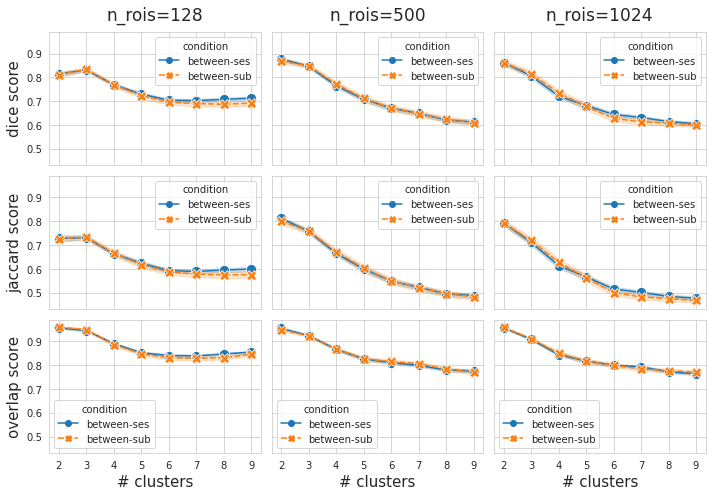

In [235]:
fig, axes = create_figure(3, len(n_rois), (10, 7), True, 'whitegrid', 'all', 'all')

for j, n in enumerate(sorted(df.n_rois.unique())):
    for i, (ax, dist_measure) in enumerate(zip(axes[:, j], ['dice', 'jaccard', 'overlap'])):
        selected_df = df.loc[
            (df.dist_measure == dist_measure) &
            (df.n_rois == n)
        ]
        sns.lineplot(
            data=selected_df,
            x='n_clusters',
            y='val',
            hue='condition',
            style='condition',
            markers=True,
            markersize=10,
            estimator=np.mean,
            ci=95,
            alpha=1.0,
            legend=True,
            ax=ax,
        )
        if i == 0:
            ax.set_title(f"n_rois={n}", fontsize=17, y=1.04)
        if j == 0:
            ax.set_ylabel(f"{dist_measure} score", fontsize=15)
        # ax.set_title(dist_measure, fontsize=17, y=1.02)
        # ax.set_ylabel('similarity score', fontsize=15)
        ax.set_xlabel('# clusters', fontsize=15)
        ax.set_xticks(df.n_clusters.unique())

fig.savefig(pjoin(tmp_dir, f"reproducibility_n{n_rois}.pdf").replace(' ', ''), bbox_inches='tight')
plt.show()

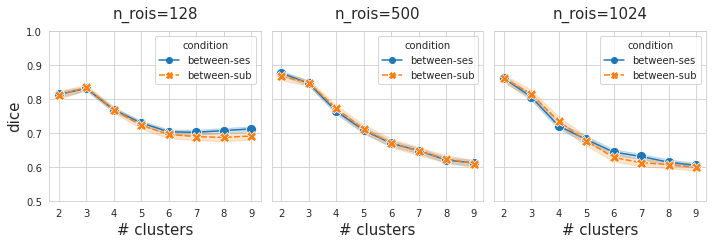

In [245]:
fig, axes = create_figure(1, len(n_rois), (10, 3.5), True, 'whitegrid', 'all', 'all')

for j, (ax, n) in enumerate(zip(axes, df.n_rois.unique())):
    selected_df = df.loc[
        (df.dist_measure == 'dice') &
        (df.n_rois == n)
    ]
    sns.lineplot(
        data=selected_df,
        x='n_clusters',
        y='val',
        hue='condition',
        style='condition',
        markers=True,
        markersize=10,
        estimator=np.mean,
        ci=95,
        alpha=1.0,
        legend=True,
        ax=ax,
    )
    ax.set_title(f"n_rois={n}", fontsize=15, y=1.04)
    if j == 0:
        ax.set_ylabel('dice', fontsize=15)
    ax.set_xlabel('# clusters', fontsize=15)
    ax.set_xticks(df.n_clusters.unique())
    ax.set_ylim(0.5, 1.0)

fig.savefig(pjoin(tmp_dir, f"reproduc_dice_n{n_rois}.pdf").replace(' ', ''), bbox_inches='tight')
plt.show()

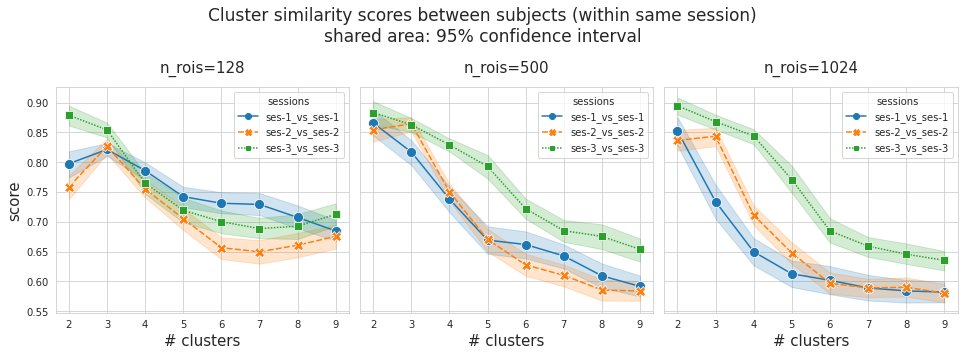

In [239]:
fig, axes = create_figure(1, len(n_rois), (13.5, 5), True, 'whitegrid', 'all', 'all')

for ax, n in zip(axes, n_rois):
    selected_df = df.loc[
        (df.dist_measure == 'dice') &
        (df.n_rois == n) &
        (df.condition == 'between-sub')
    ]
    sns.lineplot(
        data=selected_df,
        x='n_clusters',
        y='val',
        hue='sessions',
        style='sessions',
        markers=True,
        markersize=10,
        estimator=np.mean,
        ci=95,
        legend=True,
        ax=ax,
    )
    ax.set_title(f"n_rois={n}", fontsize=15, y=1.04)
    ax.set_ylabel('score', fontsize=15)
    ax.set_xlabel('# clusters', fontsize=15)
    ax.set_xticks(df.n_clusters.unique())

msg = 'Cluster similarity scores between subjects (within same session)\n'
msg += 'shared area: 95% confidence interval'
fig.suptitle(msg, fontsize=17)
fig.tight_layout()
fig.savefig(pjoin(tmp_dir, f"reproduc_same-sessions_n{n_rois}.pdf").replace(' ', ''), bbox_inches='tight')
plt.show()

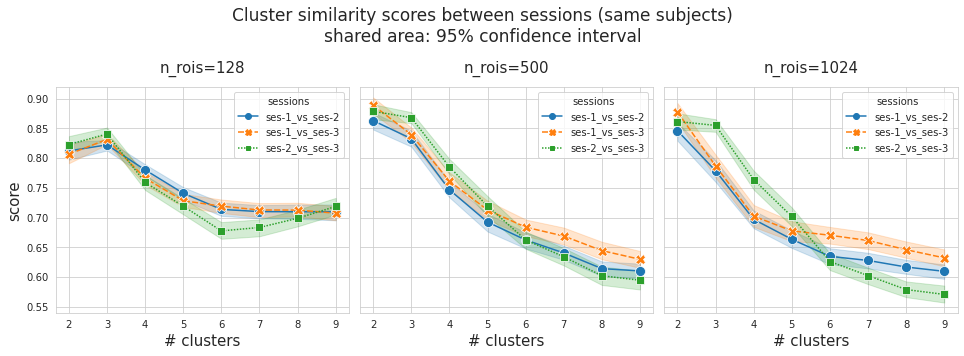

In [241]:
fig, axes = create_figure(1, len(n_rois), (13.5, 5), True, 'whitegrid', 'all', 'all')

for ax, n in zip(axes, n_rois):
    selected_df = df.loc[
        (df.dist_measure == 'dice') &
        (df.n_rois == n) &
        (df.condition == 'between-ses')
    ]
    sns.lineplot(
        data=selected_df,
        x='n_clusters',
        y='val',
        hue='sessions',
        style='sessions',
        markers=True,
        markersize=10,
        estimator=np.mean,
        ci=95,
        legend=True,
        ax=ax,
    )
    ax.set_title(f"n_rois={n}", fontsize=15, y=1.04)
    ax.set_ylabel('score', fontsize=15)
    ax.set_xlabel('# clusters', fontsize=15)
    ax.set_xticks(df.n_clusters.unique())

msg = 'Cluster similarity scores between sessions (same subjects)\n'
msg += 'shared area: 95% confidence interval'
fig.suptitle(msg, fontsize=17)
fig.tight_layout()
fig.savefig(pjoin(tmp_dir, f"reproduc_between-sessions_n{n_rois}.pdf").replace(' ', ''), bbox_inches='tight')
plt.show()

In [70]:
df_both = pd.concat([results_df, df])
#  df_both = df_both.loc[df_both.dist_measure == 'dice']
#  df_both = df_both.loc[df_both.condition == 'between-ses']
df_both = reset_df(df_both, 'none')

# df_both = df_both.pivot(index='n_rois', columns='n_clusters', values='val_mean')

In [76]:
df_both

,condition,n_rois,n_clusters,metric,dist_measure,val_mean,val_median
0,between-ses,128,2,correlation,dice,0.541351,0.541351
1,between-ses,128,2,correlation,overlap,0.602474,0.602474
2,between-ses,128,2,correlation,jaccard,0.401486,0.401486
3,between-ses,128,3,correlation,dice,0.671955,0.717494
4,between-ses,128,3,correlation,overlap,0.814105,0.973719
...,...,...,...,...,...,...,...
27211,between-sub,200,8,correlation,overlap,0.746723,0.851440
27212,between-sub,200,8,correlation,jaccard,0.467121,0.430221
27213,between-sub,200,9,correlation,dice,0.622044,0.650481
27214,between-sub,200,9,correlation,overlap,0.745213,0.820826


<AxesSubplot:xlabel='n_clusters', ylabel='val_mean'>

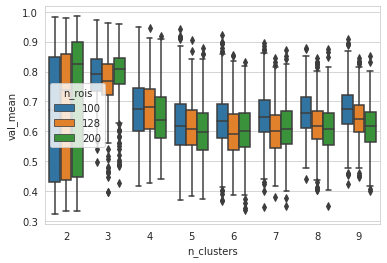

In [77]:
selected_df = df_both.loc[
    (df_both.condition == 'between-ses') &
    (df_both.dist_measure == 'dice')
]
sns.boxplot(data=selected_df, x='n_clusters', y='val_mean', hue='n_rois')

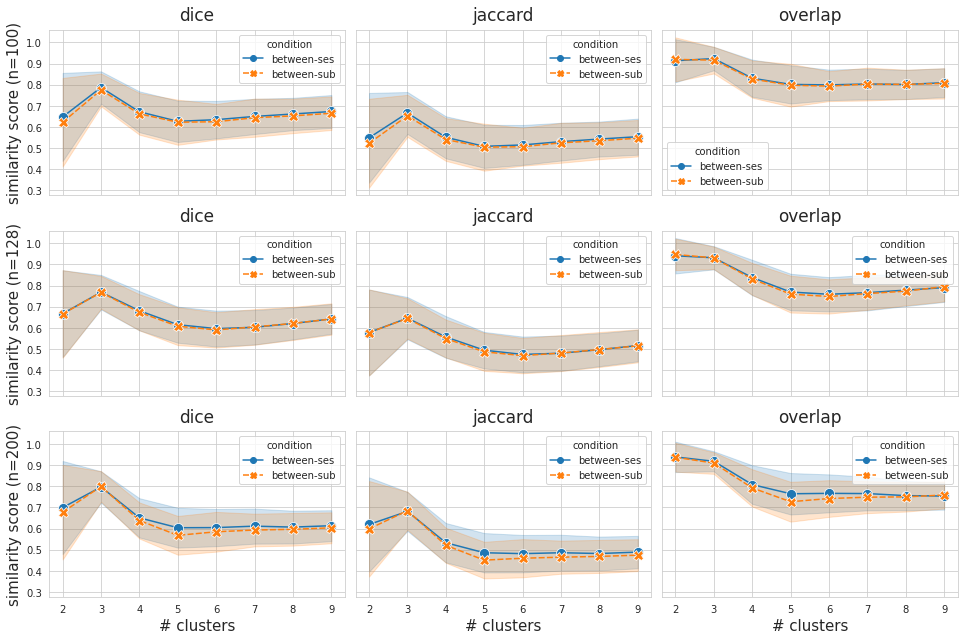

In [78]:
fig, axes = create_figure(3, 3, (13.5, 9), True, 'whitegrid', 'all', 'all')
n_rois_list = [100, 128, 200]
for i, n in enumerate(n_rois_list):
    for ax, dist_measure in zip(axes[i], ['dice', 'jaccard', 'overlap']):
        selected_df = df_both.loc[
            (df_both.dist_measure == dist_measure) &
            (df_both.n_rois == n)
        ]
        sns.lineplot(
            data=selected_df,
            x='n_clusters',
            y='val_mean',
            hue='condition',
            style='condition',
            markers=True,
            markersize=10,
            estimator=np.mean,
            ci='sd',
            legend=True,
            ax=ax,
        )
        ax.set_title(dist_measure, fontsize=17, y=1.02)
        ax.set_ylabel(f"similarity score (n={n})", fontsize=15)
        ax.set_xlabel('# clusters', fontsize=15)
        ax.set_xticks(df.n_clusters.unique())

fig.savefig(pjoin(tmp_dir, f"reproduc_n{n_rois_list}.pdf".replace(' ', '')), bbox_inches='tight')
plt.show()